# ResNet Preprocessing

Copy this notebook and set the paths to start preprocessing your data.

Note: If you are going to update this notebooks, clear the outputs before committing.

## Loading the Data

The code below loads data and labels from GCS.

You should update the paths to save the data to the right place on
your local disk.

### Arrays

In [1]:
# Keeps the data in the local filesystem in-sync with GCS
!gsutil rsync -d -r gs://elvos/numpy /home/lzhu7/elvo-analysis/data/numpy/


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...


In [2]:
import os
import pathlib
import typing

import numpy as np

In [3]:
def load_data(data_dir: str) -> typing.Dict[str, np.ndarray]:
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [4]:
data_dict = load_data('/home/lzhu7/elvo-analysis/data/numpy/')

### Labels

In [5]:
!gsutil cp gs://elvos/labels.csv /home/lzhu7/elvo-analysis/data/labels.csv

Copying gs://elvos/labels.csv...
/ [1 files][ 16.8 KiB/ 16.8 KiB]                                                
Operation completed over 1 objects/16.8 KiB.                                     


In [6]:
import pandas as pd

In [7]:
labels_df = pd.read_csv('/home/lzhu7/elvo-analysis/data/labels.csv',
                        index_col='patient_id')

## Preprocessing: Part I

If we use gs://elvos/numpy or gs://elvos/labels.csv, we'll have to do some minor
preprocessing first (removing bad data and duplicate labels).

In [8]:
def process_images(data: typing.Dict[str, np.ndarray]):
    return {id_: arr for id_, arr in data.items() if len(arr) != 1} # Remove the bad image

In [9]:
data_dict = process_images(data_dict)

In [10]:
def process_labels(labels: pd.DataFrame, data: typing.Dict[str, np.ndarray]):
    # TODO: Remove duplicate HLXOSVDF27JWNCMJ, IYDXJTFVWJEX36DO from ELVO_key
    labels = labels.loc[~labels.index.duplicated()] # Remove duplicate ids
    labels = labels.loc[list(data.keys())]
    assert len(labels) == len(data)
    return labels

In [11]:
labels_df = process_labels(labels_df, data_dict)

## Data Exploration

Simple plotting of the (mostly) unprocessed data.

For the data in `numpy/`:
- The 6 smallest image heights are: 1, 160, 160, 162, 164, 181.
- The 5 smallest image lengths/widths are: 180, 191, 193, 195, 197.

In [12]:
%matplotlib inline

In [13]:
from matplotlib import pyplot as plt

In [14]:
def plot_images(data: typing.Dict[str, np.ndarray],
                labels: pd.DataFrame,
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, patient_id in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        ax.set_title(f'patient: {patient_id[:4]}...')
        label = 'positive' if labels.loc[patient_id]["label"] else 'negative'
        ax.set_xlabel(f'label: {label}')
        plt.imshow(data[patient_id])
    fig.tight_layout()
    plt.plot()

In [15]:
# Change the input to .transpose to see different views of the data
mipped_all = {k:data_dict[k].transpose(0, 2, 1).max(axis=2) for i, k in enumerate(data_dict)}

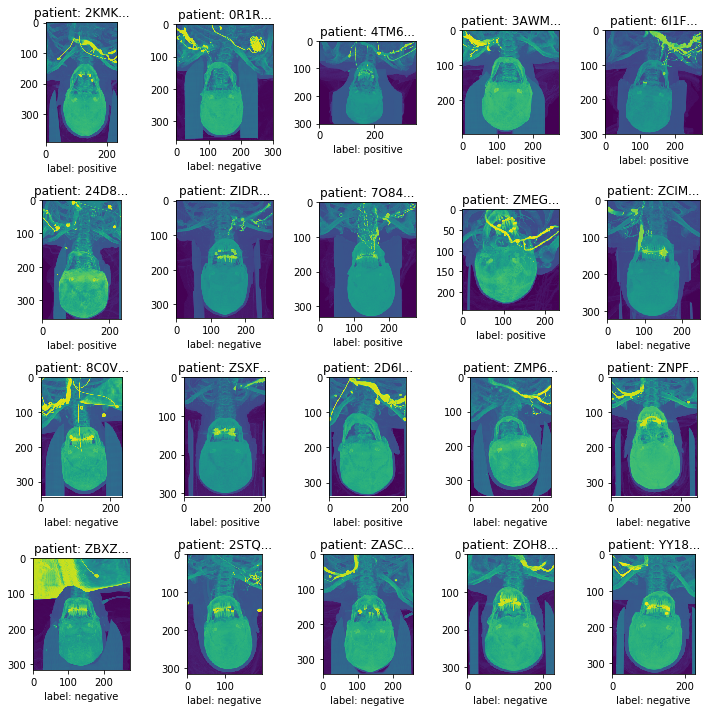

In [16]:
plot_images({k: arr for k, arr in mipped_all.items()}, labels_df, 5, offset=20)

## Preprocessing: Part II

Cropping the image, applying mip, etc.

You should

In [17]:
import scipy.ndimage

In [18]:
def crop(image3d: np.ndarray,
         output_shape) -> np.ndarray:
    """Crops a 3d image in ijk form (height as axis 0).
    """
    assert image3d.shape[1] == image3d.shape[2]
    assert output_shape[1] == output_shape[2] # For now
    assert output_shape[1] <= image3d.shape[1]
    
    lw_center = image3d.shape[1] // 2
    lw_min = lw_center - output_shape[1] // 2
    lw_max = lw_center + output_shape[1] // 2
    for i in range(len(image3d) - 1, 0, -1):
        if image3d[i, lw_center, lw_center] >= 0:
            height_max = i - 30
            break
    height_min = height_max - output_shape[0]
    
    cropped = image3d[height_min:height_max, lw_min:lw_max, lw_min:lw_max]
    assert cropped.shape == output_shape
    return cropped


def bound_pixels(image3d: np.ndarray,
                 min_bound: float,
                 max_bound: float) -> np.ndarray:
    image3d[image3d < min_bound] = min_bound
    image3d[image3d > max_bound] = max_bound
    return image3d


def mip(image3d: np.ndarray) -> np.ndarray:
    """Make sure that the array has been transposed first!
    """
    assert image3d.shape[0] == image3d.shape[1]
    return image3d.max(axis=2)


def downsample(image3d: np.ndarray, factor) -> np.ndarray:
    return scipy.ndimage.zoom(image3d, factor)
    

def to_grayscale(image2d: np.ndarray):
    return np.stack([image2d, image2d, image2d], axis=2)


def process_data(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    for id_, arr in data.items():
        try:
            arr = crop(arr, (75, 200, 200))
            arr = np.stack([arr[0:25], arr[25:50], arr[50:75]])
            arr = arr.max(axis=1)
            arr = bound_pixels(arr, -200, 400)
            arr = arr.transpose(1, 2, 0)
            assert arr.shape == (200, 200, 3)
            processed[id_] = arr
        except AssertionError:
            print(f'image for patient {id_} too small, has shape {arr.shape}')
    return processed

In [19]:
processed_dict = process_data(data_dict)

image for patient 2STQ3IYP5SV7XIPG too small, has shape (316, 198, 198)
image for patient 2B2XLE17Y0C5WJ3T too small, has shape (346, 198, 198)
image for patient X4GQ56MK0E0YNL0E too small, has shape (232, 180, 180)
image for patient TGXRI16H1J321FI0 too small, has shape (329, 195, 195)
image for patient QPDX2K3DS7IS5QNM too small, has shape (351, 191, 191)
image for patient NQXVKFP54XTD3GVF too small, has shape (269, 199, 199)
image for patient KK0ZHCZR9V87OESW too small, has shape (297, 197, 197)
image for patient 2ZF1T5U8LU7SMI4Y too small, has shape (342, 198, 198)
image for patient 6IPDMHP9V2TQJ9YR too small, has shape (305, 193, 193)
image for patient 3DMBZTLDT2LRD4LG too small, has shape (276, 198, 198)
image for patient LDS0IN2DPOSUBAX4 too small, has shape (305, 197, 197)


In [20]:
processed_df = labels_df.loc[processed_dict.keys()]

## Data Validation

Check to see that the data looks right.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

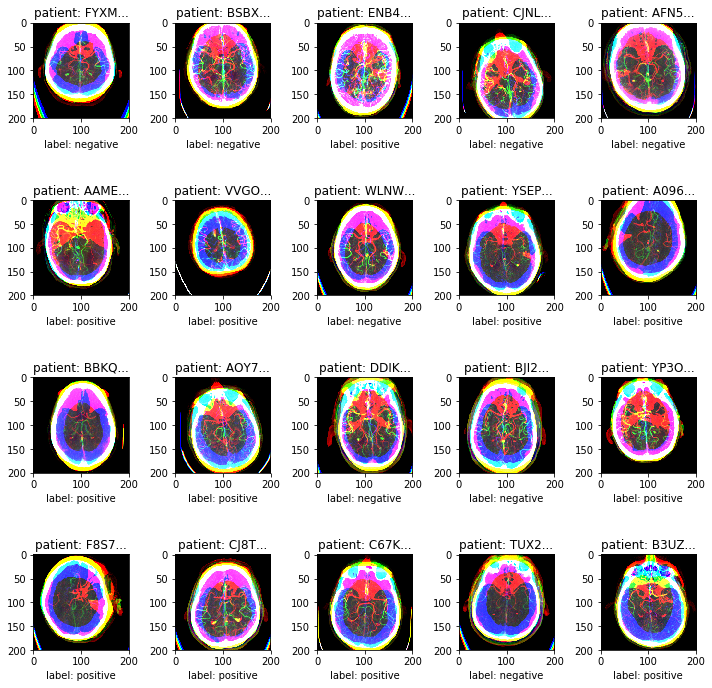

In [21]:
plot_images({k: arr for k, arr in processed_dict.items()}, labels_df, 5, offset=120)

## Saving the Data

Once you've preprocessed data to your liking, you should save the data to 
disk. Load the data from disk in your model building notebook.

In [22]:
# Changed the preprocessed path
processed_dirpath = '/home/lzhu7/elvo-analysis/data/mip_three'
os.mkdir(processed_dirpath)
arr: np.ndarray
for id_, arr in processed_dict.items():
    np.save(pathlib.Path(processed_dirpath) / f'{id_}.npy', arr)

FileExistsError: [Errno 17] File exists: '/home/lzhu7/elvo-analysis/data/mip_three'

In [ ]:
processed_df.to_csv('/home/lzhu7/elvo-analysis/data/labels_mip_three.csv')

## Sharing the Data
If the data works well in models, you should share it with others.
Make sure to update the [Code and Data Doc](https://docs.google.com/document/d/1_vaNcfZ_E5KsOZH_rNf4w_wTIr7EvI8GqpZ5o3dAUV4/edit)
if you do upload to GCS.

In [ ]:
# !gsutil rsync -d -r PATH/TO/PROCESSED/DATA gs://PATH/TO/SAVE/TO

In [ ]:
 #!gsutil rsync -d PATH/TO/PROCESSED/LABELS gs://PATH/TO/SAVE/TO